In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# generating new data by shifting images

In [2]:
df_train = pd.read_csv('mnist_train.csv')
df_test = pd.read_csv('mnist_test.csv')

In [3]:
shift = 4
end = 28 - shift

train = df_train.to_numpy()
more_train = []
more_ytrain_labels = []
for idx, row in enumerate(train):
    more_ytrain_labels.extend([[row[0]], [row[0]], [row[0]], [row[0]]])
   
    # reshape image; the float values go by columns, not rows; ie. the first 20 values make up the first COLUMN
    img = row[1:]
    img = img.reshape(28, 28)

    # create new images
    up = np.zeros((28, 28), dtype=int)
    up[:end, :] = img[shift:, :]
    
    down = np.zeros((28, 28), dtype=int)
    down[shift:, :] = img[:end, :]
    
    left = np.zeros((28, 28), dtype=int)
    left[:, :end] = img[:, shift:]
    
    right = np.zeros((28, 28), dtype=int)
    right[:, shift:] = img[:, :end]
    
    more_train.extend([up.flatten(), down.flatten(), left.flatten(), right.flatten()])
    
    
test = df_test.to_numpy()
more_test = []
more_ytest_labels = []    
for idx, row in enumerate(test):
    more_ytest_labels.extend([[row[0]], [row[0]], [row[0]], [row[0]]])

    # reshape image; the float values go by columns, not rows; ie. the first 20 values make up the first COLUMN
    img = row[1:]
    img = img.reshape(28, 28)

    # create new images
    up = np.zeros((28, 28), dtype=int)
    up[:end, :] = img[shift:, :]
    
    down = np.zeros((28, 28), dtype=int)
    down[shift:, :] = img[:end, :]
    
    left = np.zeros((28, 28), dtype=int)
    left[:, :end] = img[:, shift:]
    
    right = np.zeros((28, 28), dtype=int)
    right[:, shift:] = img[:, :end]
    
    more_test.extend([up.flatten(), down.flatten(), left.flatten(), right.flatten()])

    
# merge into one dataset
xtrain = np.vstack((train[:, 1:], np.asarray(more_train)))
xtrain.reshape((len(xtrain), 1, 28, 28))
print(len(xtrain))
               
ytrain = np.vstack((train[:, [0]], np.asarray(more_ytrain_labels)))
print(len(ytrain)) 
               
xtest = np.vstack((test[:, 1:], np.asarray(more_test)))
xtest.reshape((len(xtest), 1, 28, 28))
print(len(xtest))
               
ytest = np.vstack((test[:, [0]], np.asarray(more_ytest_labels)))
print(len(ytest))

300000
300000
50000
50000


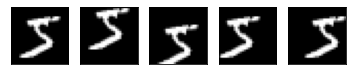

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=5)
example_shift = [train[0][1:], more_train[0], more_train[1], more_train[2], more_train[3]]
for i, col in enumerate(ax):
        col.axes.get_xaxis().set_visible(False)
        col.axes.get_yaxis().set_visible(False)
        col.imshow(example_shift[i].reshape((28, 28)), cmap='gray')
        
plt.show()

# pytorch modeling

In [5]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as f
from torch.utils.data import TensorDataset, DataLoader

## data formatting

In [6]:
batch_size = 256
## t = torchvision.transforms.Compose([ torchvision.transforms.ToTensor() ])

In [7]:
# train_temp = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=t)
xtrain_tensor = torch.Tensor(xtrain)
ytrain_tensor = torch.Tensor(ytrain)
mnist = torch.utils.data.TensorDataset(xtrain_tensor, ytrain_tensor)
mnist_dl = DataLoader(mnist, batch_size=batch_size)

xtest_tensor = torch.Tensor(xtest)
ytest_tensor = torch.Tensor(ytest)
mnist_test = torch.utils.data.TensorDataset(xtest_tensor, ytest_tensor)
mnist_test_dl = DataLoader(mnist_test)

## creating model, training/testing

In [10]:
def mnist__lenet5_classifier():
    # input channel 1, output channel 6, kernel size 5
    # 2 convolutional layers + 3 linear layers
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10) 
    )
    
    return model

In [11]:
def prediction_accuracy(model, data):
    total_imgs = 0
    correct_preds = 0
    
    # data is a data loader
    for i, (images, labels) in enumerate(data):
        # digit output vector
        out = model(images)
        
        # maximum output value and its index (ie. the digit)
        value, pred = torch.max(out, 1)
        
        # count each image given as input; count correct
        total += out.size(1)
        correct += torch.sum(pred == labels)
           

In [14]:
 def cnn_train(num_epoch=10, lr=1e-3, device='cpu'):
    accuracies = []
    max_accuracy = 0

    cnn = mnist_lenet5_classifier().to(device)
    cel = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters, lr=lr)

    for ep in range(num_epoch):
        for i, (images, labels) in enumerate(mnist_dl):
            images = images.to(device)
            labels = labels.to(device)

            # resets gradients
            optimizer.zero_grad()

            # outputs of model
            pred = cnn(images)

            # calculate loss + backpropagate
            loss = cec(pred, labels)
            loss.backward()

            # perform parameter update
            optimizer.step()

        acc = float(prediction_accuracy(mnist_test_dl))
        accuracies.append(acc)

        # select model w best prediction accuracy
        if acc > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = acc
            print(f'new best model with accuracy {acc}')

        print(f'epoch {i+1}: accuracy {acc}')
            
    # plot prediction accuracies by epoch
    plt.plot(accuracies)
    
    return best_model